In [3]:
from __future__ import print_function

from collections import defaultdict, deque
import datetime
import pickle
import time
import torch.distributed as dist
import errno
import random

import collections
import os
import sys
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from dataset import SIIM_MaskRCNN_Dataset
from util import mask2rle, rle2mask, dice

ImageFile.LOAD_TRUNCATED_IMAGES = True


In [4]:
# const

data_path = '../../data/siim-pneumothorax/'


## helpers

In [5]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = self.delimiter.join([
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}',
            'max mem: {memory:.0f}'
        ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(
                    i, len(iterable), eta=eta_string,
                    meters=str(self),
                    time=str(iter_time), data=str(data_time),
                    memory=torch.cuda.max_memory_allocated() / MB))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)
    

In [6]:
# Plot some samples
import colorsys
from matplotlib import patches,  lines

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask > 0.5,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_sample(img, target=None, result=None):
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    
    # TODO : check type
    img = img * 255.
    ax0.imshow(img.astype(np.uint8))
    
    # target
    if target is not None and len(target['boxes']) > 0:
        target_img = img.astype(np.uint32).copy()
        target_colors = random_colors(len(target['boxes']))
        
        for box, mask, color in zip(target['boxes'], target['masks'], target_colors):
            # box
            x1, y1, x2, y2 = box
            
            p = patches.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=2,
                alpha=0.7,
                linestyle="dashed",
                facecolor='none',
                edgecolor=color,
            )
            ax1.add_patch(p)

            # mask
            target_img = apply_mask(target_img, mask.cpu().numpy().squeeze(), color)

            ax1.imshow(target_img.astype(np.uint8))
        
    # result
    if result is not None and len(result['scores']) > 0:
        result_img = img.astype(np.uint32).copy()
        result_colors = random_colors(len(target['boxes']))
        
        for box, score, mask, color in zip(result['boxes'], result['scores'], result['masks'], result_colors):
            x1, y1, x2, y2 = box
            
            p = patches.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=2,
                alpha=0.7,
                linestyle="dashed",
                facecolor='none',
                edgecolor=color,
            )
            ax2.add_patch(p)

            # score for result
            ax2.text(
                x1,
                y1+8,
                '{:.3f}'.format(score),
                color='w',
                size=11,
                backgroundcolor='none'
            )

            # mask
            result_img = apply_mask(result_img, mask.cpu().numpy(), color)
        
        ax2.imshow(result_img.astype(np.uint8))

    ax1.set_title('target')
    ax2.set_title('pred')
    
    plt.show()
    

In [12]:
def train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(train_data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    
    # TODO : save checkpoint
    torch.save(model_ft.state_dict(), "mrcnn_model_{}.pth".format(epoch))
        

In [13]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug.augmentables.segmaps import SegmentationMapOnImage

# actual train aug
'''
train_aug = iaa.Sequential(
    [
        iaa.Sometimes(0.5, iaa.ContrastNormalization((0.5, 1.5))),
        iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0.0, 0.75))),
        iaa.Fliplr(0.5),
        iaa.Sometimes(
            0.5,
            iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode=ia.ALL,
                pad_cval=0
            )
        ),
        iaa.Sometimes(
            0.5,
            iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-15, 15),
                shear=(-10, 10),
                order=[1],
                cval=0,
                mode=ia.ALL
            )
        ),
        iaa.Sometimes(
            0.5,
            iaa.OneOf([
                iaa.AdditiveGaussianNoise(scale=(0, 0.025*1)),
                iaa.Dropout(p=(0, 0.05)),
            ])
        ),
    ]
)
'''

train_aug = iaa.Sequential(
    [
        iaa.Fliplr(0.8),
        iaa.Sometimes(
            0.5,
            iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode=ia.ALL,
                pad_cval=0
            )
        )
    ]
)

dataset_train = SIIM_MaskRCNN_Dataset(
    os.path.join(data_path, "train-rle.csv"),
    os.path.join(data_path, 'train_png'),
    os.path.join(data_path, 'mrcnn_siim_5fold'),
    fold=0,
    phrase='train_pos',
    height=1024,
    width=1024,
    aug=train_aug
)


100%|██████████| 11582/11582 [00:02<00:00, 4908.15it/s]


In [14]:
print(len(dataset_train))

1903


tensor(1.)


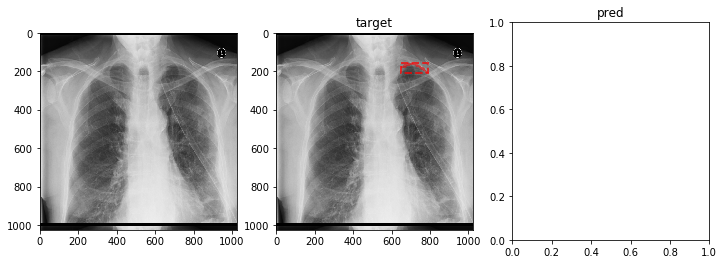

tensor(1.)


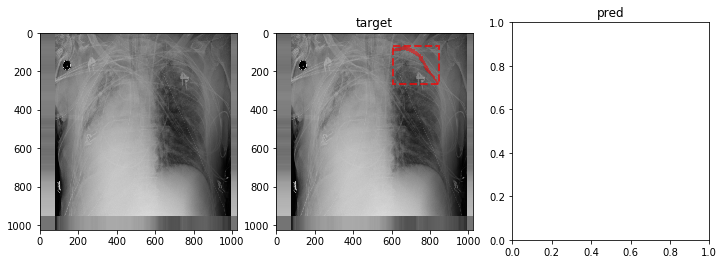

tensor(1.)


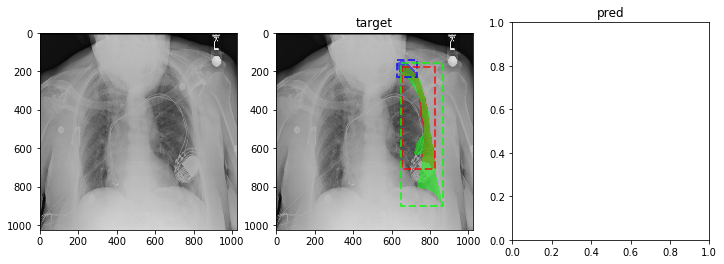

tensor(1.)


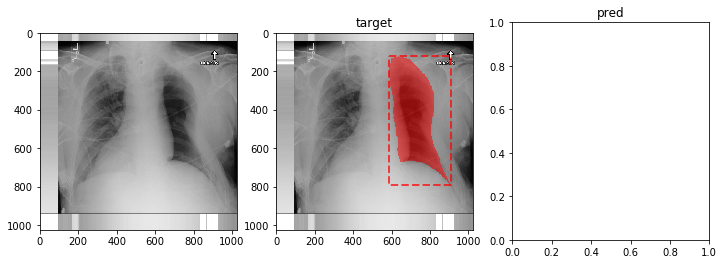

tensor(1.)


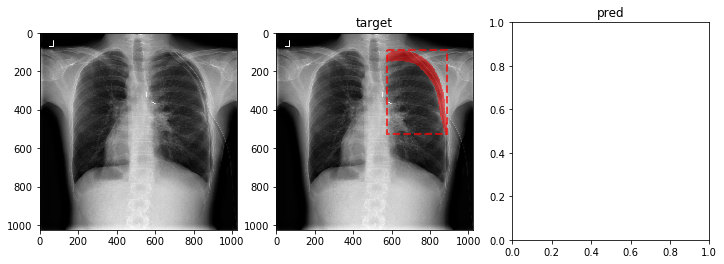

In [15]:
# let's load and watch some sample

# let's load and watch some sample
sample_count = 5

for i, data in enumerate(dataset_train):
    img, target = data
    target['masks'] = target['masks']
    print(torch.max(target['masks']))
    
    plot_sample(img.cpu().numpy().transpose((1, 2, 0)), target=target)
        
    if i == sample_count - 1:
        break


In [16]:
# create mask rcnn model
num_classes = 2
device = torch.device('cuda:0')

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(
    pretrained=True,
    progress=True,
    # box_nms_thresh=0.,
)

# re-init box predictor
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# re-init mask predictor
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = True
    

In [22]:
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=8,
    collate_fn=lambda x: tuple(zip(*x)))


In [23]:
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)


In [25]:
num_epochs = 12
for epoch in range(num_epochs):
    train_one_epoch(model_ft, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()
    

Epoch: [0]  [  0/952]  eta: 0:40:33  lr: 0.000002  loss: 2.8877 (2.8877)  loss_classifier: 0.6039 (0.6039)  loss_box_reg: 0.0197 (0.0197)  loss_mask: 1.8616 (1.8616)  loss_objectness: 0.3765 (0.3765)  loss_rpn_box_reg: 0.0260 (0.0260)  time: 2.5566  data: 1.7350  max mem: 5278
Epoch: [0]  [100/952]  eta: 0:06:12  lr: 0.000107  loss: 0.7100 (1.3176)  loss_classifier: 0.1047 (0.2330)  loss_box_reg: 0.0508 (0.0490)  loss_mask: 0.4928 (0.9130)  loss_objectness: 0.0442 (0.1087)  loss_rpn_box_reg: 0.0097 (0.0139)  time: 0.4185  data: 0.0137  max mem: 6410
Epoch: [0]  [200/952]  eta: 0:05:24  lr: 0.000212  loss: 0.6990 (1.0383)  loss_classifier: 0.0985 (0.1750)  loss_box_reg: 0.0551 (0.0572)  loss_mask: 0.4172 (0.7040)  loss_objectness: 0.0495 (0.0867)  loss_rpn_box_reg: 0.0090 (0.0155)  time: 0.4230  data: 0.0138  max mem: 6467
Epoch: [0]  [300/952]  eta: 0:04:40  lr: 0.000317  loss: 0.6164 (0.9106)  loss_classifier: 0.0985 (0.1530)  loss_box_reg: 0.0703 (0.0621)  loss_mask: 0.3940 (0.6111) 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/xd/anaconda3/envs/siim/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/xd/anaconda3/envs/siim/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/xd/anaconda3/envs/siim/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/xd/anaconda3/envs/siim/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/xd/anaconda3/envs/siim/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/xd/anaconda3/envs/siim/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/xd/anaconda3/envs/siim/lib/python3.6/multiprocessing/connectio

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/xd/anaconda3/envs/siim/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/xd/anaconda3/envs/siim/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/xd/anaconda3/envs/siim/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/xd/anaconda3/envs/siim/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [ ]:
torch.save(model_ft.state_dict(), "mrcnn-model.bin")


## eval

In [12]:
# const

model_path = 'mrcnn_model_5.pth'
image_size = 800

In [13]:
dataset_val = SIIM_MaskRCNN_Dataset(
    os.path.join(data_path, "train-rle.csv"),
    os.path.join(data_path, 'train_png'),
    os.path.join(data_path, 'SIIM_5-FOLD_POS'),
    fold=0,
    height=image_size,
    width=image_size,
    phrase='val'
)

val_data_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=4, shuffle=False, num_workers=8,
    collate_fn=lambda x: tuple(zip(*x)))


100%|██████████| 11582/11582 [00:00<00:00, 14024.53it/s]


dataset


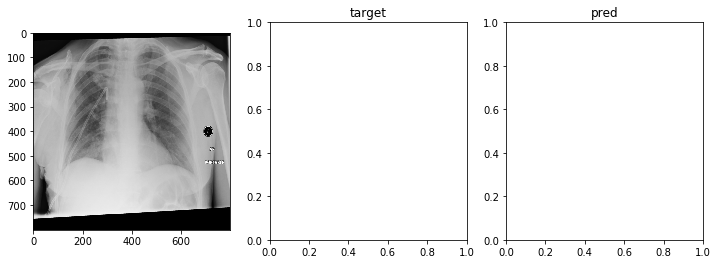

loader


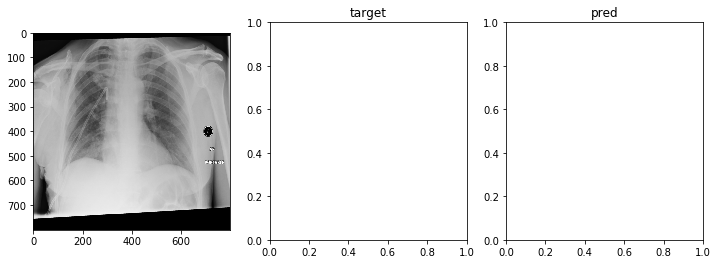

In [14]:
for data in dataset_val:
    img, target = data
    print('dataset')
    plot_sample(img.numpy().transpose(1, 2, 0))
    
    break
        
for imgs, tgts in val_data_loader:
    for img in imgs:
        print('loader')
        plot_sample(img.numpy().transpose(1, 2, 0))
        
        break
    break

In [15]:
# create mask rcnn model
num_classes = 2
device = torch.device('cuda:1')

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(
    pretrained=True,
    progress=True,
    box_nms_thresh=0.,
    box_detections_per_img=4,
    box_score_thresh=0.45
)

# re-init box predictor
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# re-init mask predictor
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model_ft.load_state_dict(torch.load(model_path))
model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = False
    
model_ft.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

In [16]:
def merge_mask(masks):
    mask = np.amax(masks, axis=0)

    return mask

In [20]:
# find out best score_threshold
score_thres_start = 0.01
score_thres_end = 1
score_thres_step = 0.01

score_thresholds = np.arange(0.01, 1, 0.01)
dice_list = [[] for i in range(len(score_thresholds))]

with torch.no_grad():
    with tqdm(total=len(val_data_loader), file=sys.stdout) as pbar:
        for images, targets in val_data_loader:
            
            original_images = list(image.cpu().numpy().copy().transpose((1, 2, 0)) for image in images)
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            results = model_ft(images)
            
            # masks.shape = [N, C, W, H], C = 1
            # convert to [N, W, H]
            for result in results:
                result['masks'] = torch.squeeze(result['masks'], 1)

            '''
            for i, result in enumerate(results):
                plot_sample(
                    original_images[i],
                    targets[i],
                    results[i]
                )
            '''
            # apply score_thresholds
            for sindex, score_threshold in enumerate(score_thresholds):
                
                batch_masks = []
                for i, result in enumerate(results):
                    # merge masks of each sample
                    sample_masks = []
                    
                    for score, mask in zip(result['scores'], result['masks']):
                        if score > score_threshold:
                            sample_masks.append(mask.cpu().numpy().squeeze())
                    
                    if len(sample_masks) > 0:
                        sample_mask = merge_mask(sample_masks)
                    else:
                        sample_mask = np.zeros_like(targets[0]['masks'].cpu().numpy()[0].squeeze())
                        
                    batch_masks.append(sample_mask)
                    # [print(mask.shape) for mask in masks]
                
                # dice metric of this batch
                metric = dice(
                    torch.from_numpy(np.stack(batch_masks)).squeeze(),
                    torch.stack([torch.from_numpy(merge_mask(target['masks'].cpu().numpy())) for target in targets]).squeeze()
                )
        
                dice_list[sindex].append(metric.item())
            
            pbar.update(1)

dice_list = [np.mean(scores) for scores in dice_list]


100%|██████████| 119/119 [03:21<00:00,  1.58s/it]


best score_threshold 0.47467219616685596 @ 0.5700000000000001


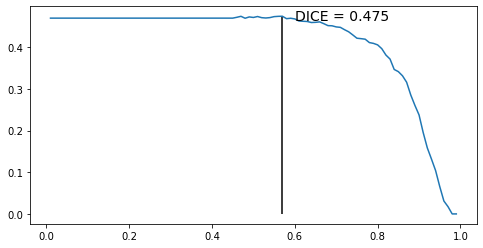

In [21]:
dice_list = np.array(dice_list)

best_dice = dice_list.max()
best_thr = score_thresholds[dice_list.argmax()]

print('best score_threshold {} @ {}'.format(best_dice, best_thr))

plt.figure(figsize=(8,4))

plt.plot(score_thresholds, dice_list)
plt.vlines(x=best_thr, ymin=dice_list.min(), ymax=dice_list.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);

plt.show()

## test

In [7]:
# const

model_path = 'mrcnn_model_5.pth'
image_size = 800

best_thr = 0.57

In [8]:
test_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
test_df = test_df.drop_duplicates('ImageId', keep='last').reset_index(drop=True)

# create mask rcnn model
num_classes = 2
device = torch.device('cuda:0')

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(
    pretrained=True,
    progress=True,
    box_score_thresh=best_thr,
    # box_nms_thresh=0.03,
    box_detections_per_img=4,
)

# re-init box predictor
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# re-init mask predictor
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model_ft.load_state_dict(torch.load(model_path))
model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = False
    
model_ft.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

In [9]:
test_trans = transforms.ToTensor()

all_scores = []
all_masks = []
all_ids = []

with torch.no_grad():
    for index, row in tqdm(test_df.iterrows(), total=len(test_df), file=sys.stdout):
        image_id = row['ImageId']
        img_path = os.path.join(data_path, 'test_png', '{}.png'.format(image_id))

        img = Image.open(img_path).convert('RGB')
        width, height = img.size

        img = img.resize((image_size, image_size), resample=Image.BILINEAR)
        img = test_trans(img)

        result = model_ft([img.to(device)])[0]

        all_scores.append(result['scores'].cpu().numpy())
        all_masks.append(result['masks'].cpu().numpy())
        all_ids.append(image_id)


100%|██████████| 1372/1372 [02:19<00:00,  9.88it/s]


In [12]:
# use leakage!

sample_df = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

# this part was taken from @raddar's kernel: https://www.kaggle.com/raddar/better-sample-submission
masks_ = sample_df.groupby('ImageId')['ImageId'].count().reset_index(name='N')
masks_ = masks_.loc[masks_.N > 1].ImageId.values

leak_scores = []
leak_masks = []
leak_ids = []

for scores, masks, uid in zip(all_scores, all_masks, all_ids):
    if uid in masks_:
        leak_scores.append(scores)
        leak_masks.append(masks)
        leak_ids.append(uid)
    else:
        leak_scores.append([])
        leak_masks.append([])
        leak_ids.append(uid)
        

In [13]:
import multiprocessing as mp
import json

sub_list = []
mask_size = 1024

def mask_worker(task):
    image_id = task[0]
    mask = task[1]

    mask = mask.transpose((1, 2, 0))

    mask_img = Image.fromarray(mask.squeeze())
    mask = np.asarray(mask_img.resize((mask_size, mask_size), resample=Image.BILINEAR))
    
    # soft to hard mask
    mask = (mask[:, :] * 255. > 127).astype(np.uint8)
    
    # convert to rle
    rle = mask2rle(mask, mask_size, mask_size)
    
    if rle == ' ':
        rle = ' -1'
    
    return [image_id, rle]

task_list = []

for image_id, masks in zip(leak_ids, leak_masks):
    for mask in masks:
        task_list.append([image_id, mask])
            
pool = mp.Pool()

# ok, get all rle
sub_list = pool.map(mask_worker, task_list)
    
pool.close()

# now append -1
task_ids = [task[0] for task in task_list]

for uid in list(test_df['ImageId']):
    if uid not in task_ids:
        sub_list.append([uid, ' -1'])
        
print(len(sub_list))

1439


In [ ]:
sub_list = []
mask_size = 1024

with tqdm(total=len(all_ids)) as pbar:
    for image_id, scores, masks in zip(all_ids, all_scores, all_masks):
        if len(masks) > 0:
            filtered_masks = []

            # filter mask with score_threshold
            for score, mask in zip(scores, masks):
                if score > best_thr:
                    filtered_masks.append(mask)

            if len(filtered_masks) <= 0:
                rle = ' -1'

                sub_list.append([image_id, rle])
            else:
                # merge masks
                # mask = np.amax([mask.squeeze().cpu().numpy() for mask in masks], axis=0)

                for mask in filtered_masks:
                    # post-processing - resize and convert to hard mask
                    res = transforms.ToPILImage()(torch.from_numpy(mask))
                    res = np.asarray(res.resize((mask_size, mask_size), resample=Image.BILINEAR))

                    res = (res[:, :] * 255. > 127).astype(np.uint8)

                    # plot_sample(np.array(img).transpose((1, 2, 0)), result_mask=res)

                    rle = mask2rle(res.T, mask_size, mask_size)
                    # print('rle {}'.format(rle))

                    sub_list.append([image_id, rle])
        else:
            # print(image_id)
            rle = " -1"

            sub_list.append([image_id, rle])
            
        pbar.update(1)
        
print(sub_list)

In [14]:
sub_df = pd.DataFrame(sub_list, columns=['ImageId', 'EncodedPixels'])
sub_df.head(5)
sub_df.to_csv('mrcnn_sub_5_{}.csv'.format(best_thr), index=False)


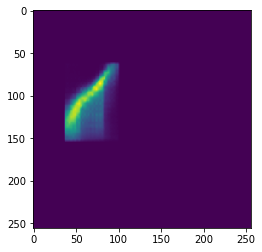

In [13]:
plt.imshow(result['masks'][0].permute(1, 2, 0).squeeze().cpu().numpy())
plt.show()